In [9]:
import numpy as np

import numpy as np

def kumar_distribution(lambda_, b, y, N=10000):
    dist = []

    if y >= b:
        # Case 1: prediction ≥ threshold
        k = int(np.floor(lambda_ * b))
        size = min(k, N)
        denominator = b * (1 - (1 - 1 / b) ** k)
        for i in range(1, size + 1):
            qi = ((b - 1) / b) ** (k - i) * (1 / denominator)
            dist.append(qi)
    else:
        # Case 2: prediction < threshold
        l = int(np.ceil(b / lambda_))
        size = min(l, N)
        denominator = b * (1 - (1 - 1 / b) ** l)
        for i in range(1, size + 1):
            ri = ((b - 1) / b) ** (l - i) * (1 / denominator)
            dist.append(ri)

    pi_array = np.array(dist, dtype=float)
    pi_array /= pi_array.sum()

    threshold = 1e-12
    while len(pi_array) > 0 and pi_array[-1] < threshold:
        pi_array = pi_array[:-1]

    return pi_array


def equalizing_distribution(m, n, b, total_length=None):
    """
    Generate equalizing distribution π_i^{eq}[m,n] from Theorem 4.2
    Output is list π[i-1] = π_i with length = total_length or n by default
    """
    if m > n:
        raise ValueError("m must be ≤ n")

    ratio = b / (b - 1)
    factor = (m + (b - 1)) / m
    geometric_sum = ratio ** (n - m) - 1
    pi_m = 1 / (1 + factor * geometric_sum)

    dist = []
    for i in range(m, n + 1):
        if i == m:
            pi_i = pi_m
        else:
            pi_i = pi_m * ((m + (b - 1)) / (m * (b - 1))) * (ratio ** (i - m - 1))
        dist.append((i, pi_i))

    # Convert to full list form from i=1 to total_length
    if total_length is None:
        total_length = n
    pi_array = [0.0] * total_length
    for i, p in dist:
        if i <= total_length:
            pi_array[i - 1] = p
    return pi_array

def compute_ratio(pi, x, b):
    """
    Compute R(π, x, b) = [sum_{i=1}^x π_i (i - 1 + b) + sum_{i=x+1}^∞ π_i * x] / min{x, b}
    Input π is a list where π[i-1] = π_i
    """
    pi = np.array(pi)
    n = len(pi)

    # Extend if needed
    if x >= n:
        pi = np.pad(pi, (0, x - n + 10), mode='constant')

    # First part: sum_{i=1}^x π_i * (i - 1 + b)
    part1 = sum(pi[i] * (i + b) for i in range(x))  # i from 0 to x-1 ⇒ i+1 = actual index

    # Second part: sum_{i=x+1}^∞ π_i * x
    part2 = np.sum(pi[x:]) * x

    denom = min(x, b)
    return (part1 + part2) / denom

In [10]:
lambda_ = 0.4
b = 10
y = 12
x = 3

# Kumar's distribution
pi_kumar = kumar_distribution(lambda_, b, y, N=50)
R_kumar = compute_ratio(pi_kumar, x, b)
#print(f"Kumar R(π, x={x}, b={b}) = {R_kumar:.4f}")

In [11]:
b = 5
m = 1
n = 5
x = 2

# Equalizing distribution
pi_eq = equalizing_distribution(m=m, n=n, b=b, total_length=50)
#print(pi_eq)
R_eq = compute_ratio(pi_eq, x, b)
#print(f"Equalizing R(π_eq, x={x}, b={b}) = {R_eq:.4f}")

In [12]:
def operation_A(pi_init, y, b):
    """
    Perform Algorithm 2 (Operation A) using exact linear solution.
    """
    pi = pi_init.copy()
    n = len(pi)
    r = n
    gamma = compute_ratio(pi, 1, b)
    #print(gamma)

    while True:
        if r == 1:
            pi = [0.0] * max(n, b + 2)
            pi[0] = 1 / b
            pi[b] = (b - 1) / b
            return pi

        if r <= y + 1 - b:
            return pi

        # Step 1: merge r into y+1
        pi[y] += pi[r - 1]
        pi[r - 1] = 0

        # Step 2: check ratio
        current_ratio = compute_ratio(pi, y + 1, b)
        #print(r)
        #print(pi[y])
        #print("curr_ratio", current_ratio)
        if current_ratio < gamma:
            r -= 1
            continue

        # Step 3: exact linear solve
        M = 1 - sum(pi[:r - 1])
        S = sum(pi[i] * (i + b) for i in range(r - 1))
        denom = b
        A = r - 1 + b
        B = y + b

        # Solve: (S + x*A + (M - x)*B)/denom = gamma
        # => S + x*A + M*B - x*B = gamma * denom
        # => x*(A - B) = gamma * denom - S - M*B
        num = gamma * denom - S - M * B
        denom_x = A - B
        x = num / denom_x
        y_mass = M - x
        #print(y_mass)

        # Update values
        pi[r - 1] = float(x)
        pi[y] = float(y_mass)
        #print(pi)
        #print("after ratio", compute_ratio(pi, y + 1, b))
        #print("after ratio y", compute_ratio(pi, y, b))
        return pi

In [13]:
b = 10
lambda_ = 0.8
n =  8 #int(lambda_ * b)
pi_eq = equalizing_distribution(1, n, b, total_length=50)

y = 11
pi_updated = operation_A(pi_eq, y=y, b=b)
#print(pi_updated)

#print("Kumar's Alg")
#print(f"Robustness: R = {compute_ratio(pi_eq, 1, b):.4f}")
#print(f"Consistency: R = {compute_ratio(pi_eq, y, b):.4f}")

#print("Our Alg")
#print(f"Robustness: R = {compute_ratio(pi_updated, 1, b):.4f}")
#print(f"Consistency: R = {compute_ratio(pi_updated, y, b):.4f}")

In [14]:
b = 10
lambda_ = 0.2
n =  2 #int(lambda_ * b)
pi_eq = equalizing_distribution(1, n, b, total_length=50)

y = 10
pi_updated = operation_A(pi_eq, y=y, b=b)

#print("Kumar's Alg")
#print(f"Robustness: R = {compute_ratio(pi_eq, 1, b):.4f}")
#print(f"Consistency: R = {compute_ratio(pi_eq, y, b):.4f}")

#print(pi_updated)
#print("Our Alg")
#print(f"Robustness: R = {compute_ratio(pi_updated, 1, b):.4f}")
#print(f"Consistency: R = {compute_ratio(pi_updated, y, b):.4f}")

In [15]:
import numpy as np
from numpy.linalg import solve, LinAlgError

def compute_ratio_matrix_row(x, b, size):
    row = np.zeros(size)
    minxb = min(x, b)
    for i in range(size):
        if i + 1 <= x:
            row[i] = (i + b) / minxb
        else:
            row[i] = x / minxb
    return row

def build_linear_system_fixed(step, r, y, b, target_gamma=None):
    if step == 1:
        prefix_indices = list(range(1, r + 1))
    else:
        prefix_indices = list(range(1, r)) if r > 1 else []

    suffix_indices = list(range(y + 1, b + 1)) if y + 1 <= b else []
    suffix_len = max(0, b - y)
    total_vars = r + suffix_len

    A = []
    rhs = []

    for x in prefix_indices + suffix_indices:
        row = compute_ratio_matrix_row(x, b, b)
        row_prefix = row[:r]
        row_suffix = row[y:] if y < b else np.array([])
        row_filtered = np.concatenate([row_prefix, row_suffix])
        if step == 1:
            A.append(np.append(row_filtered, -1.0)) 
            rhs.append(0.0)
        else:
            A.append(row_filtered)
            rhs.append(target_gamma)

    norm_row = np.concatenate([
        np.ones(r),
        np.ones(suffix_len)
    ])
    if step == 1:
        A.append(np.append(norm_row, 0.0))
    else:
        A.append(norm_row)
    rhs.append(1.0)

    A = np.array(A)
    rhs = np.array(rhs)
    return A, rhs

def operation_B(y, b, target_gamma, total_length = 100):
    r = 1
    final_solution = equalizing_distribution(y+1, b, b, total_length)

    while True:
        A1, rhs1 = build_linear_system_fixed(step=1, r=r, y=y, b=b)
        #print(A1,rhs1)
        try:
            sol1 = solve(A1, rhs1)
            pi_gamma = sol1[:-1]
            gamma_prime = sol1[-1]
            if gamma_prime <= target_gamma and np.all(pi_gamma >= -1e-8):
                break
        except LinAlgError:
            pass
        if r == y + 1:
            return equalizing_distribution(1, b, b, total_length), r
        r += 1
        #if r > b:
            #raise RuntimeError("Step 1: input gamma is too small")

    A3, rhs3 = build_linear_system_fixed(step=3, r=r, y=y, b=b, target_gamma=target_gamma)
    try:
        sol3 = solve(A3, rhs3)
        #print(A3)
        #print(rhs3)
        if np.any(sol3 < -1e-8):
            print("r", r)
            print("A3", A3)
            print("rhs3", rhs3)
            print("sol3", sol3)
            raise RuntimeError("Step 3: Negative solution occurs")
        final_solution = np.zeros(b)
        final_solution[:r] = sol3[:r]
        final_solution[y:] = sol3[r:]
        final_solution = np.clip(final_solution, 0, 1)
        final_solution /= final_solution.sum()
    except LinAlgError:
        raise RuntimeError("Step 3: There is no solution to the linear system")

    return final_solution, r

In [16]:
y = 2
b = 5
gamma = 1.5

pi_final, r_used = operation_B(y, b, gamma)

#print(f"Final π' with r = {r_used}")
#for i, p in enumerate(pi_final, 1):
    #print(f"π'_{i} = {p:.6f}")
#print(pi_final)

In [17]:
lambda_ = 0.92
kumar_dist = kumar_distribution(lambda_, b, y, N=50)

#print("Kumar's Alg")
#print("Consistency:", compute_ratio(kumar_dist, y, b))
#print("Robustness:", compute_ratio(kumar_dist, 100 , b))


#print("Our Alg")
#print("Consistency:", compute_ratio(pi_final, y, b))
#print("Robustness:", compute_ratio(pi_final, 100, b))

In [29]:
import math

def RSR(y, gamma, b, total_length=100):
    e_b = (1 + 1 / (b-1)) ** b
    #print(e_b / (e_b - 1))
    #print(b-3)
    if gamma <= e_b / (e_b - 1):
        gamma = (e_b / (e_b - 1))
    if gamma >= b - 2:
        gamma = b - 2 - 1e-8
    n = math.ceil(math.log(1 + 1 / (gamma - 1), b /(b-1)))
    if y >= b:
        pi = operation_A(equalizing_distribution(1, n, b, total_length), y, b)
    elif y < b:
        gamma_rec = ((b/(b-1)) ** n - 1) ** (-1) + 1
        lower = compute_ratio(equalizing_distribution(1, b, b, total_length), 1, b)
        upper = compute_ratio(equalizing_distribution(y+1, b, b, total_length), b, b)
        #if gamma_rec < lower:
            #gamma_rec = lower + 1e-8



        
        if gamma_rec > upper:
            gamma_rec = upper
        #print(lower)
        #print("gamma_rec:", gamma_rec)
        pi = operation_B(y, b, gamma_rec)[0]
    return pi

In [19]:
def Consistency(pi, y, b):
    return compute_ratio(pi, y, b)

def Robustness(pi, b, total_length = 100):
    rob = 1
    for x in range(total_length):
        if compute_ratio(pi, x, b) > rob:
            rob = compute_ratio(pi, x, b)
    return rob

In [20]:
gamma = 1.8

dist = RSR(7, gamma, 5)
#print(dist)

#print(Consistency(dist, 7 ,5))
#print(Robustness(dist, 5))

In [21]:
def Kumar_vs_Ours(lambda_, b, y):
    #print("b:", b)
    #print("prediction y:", y)
    total_length = max(math.floor(b / lambda_), y) + 10
    Kumar_dist = kumar_distribution(lambda_, b, y, total_length)
    #print("Kumar's Alg:")
    Kumar_con = Consistency(Kumar_dist, y, b)
    Kumar_rob = Robustness(Kumar_dist, b, total_length)
    #print("Consistency", Kumar_con)
    #print("Robustness", Kumar_rob)
    
    our_dist = RSR(y, Robustness(Kumar_dist, b, total_length)+1e-4, b, total_length)
    #print("Our Alg:")
    Our_con = Consistency(our_dist, y, b)
    Our_rob = Robustness(our_dist, b, total_length)
    #print("Consistency", Our_con)
    #print("Robustness", Our_rob)
    #print()
    return Kumar_con, Kumar_rob, Our_con, Our_rob

In [22]:
Kumar_vs_Ours(0.5, 20, 38)
# Kumar_vs_Ours(0.5, 10, 12)

/var/folders/3v/p3bmjb3n73l95z9dcb8kb8880000gn/T/ipykernel_26454/145372099.py:84: RuntimeWarning: invalid value encountered in scalar divide
  return (part1 + part2) / denom


(np.float64(1.246065359345489),
 np.float64(2.492130718690978),
 np.float64(1.24606535934549),
 np.float64(2.49213071869098))

In [23]:
import matplotlib.pyplot as plt

def plot_comparison(lambda_, b):
    ys = list(range(1, 2 * b + 1))
    kumar_cons, kumar_rob = [], []
    our_cons, our_rob = [], []

    for y in ys:
        kc, kr, oc, orob = Kumar_vs_Ours(lambda_, b, y)
        kumar_cons.append(kc)
        kumar_rob.append(kr)
        our_cons.append(oc)
        our_rob.append(orob)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.plot(ys, kumar_cons, label="Kumar's Algorithm", marker='o', color="blue")
    ax1.plot(ys, our_cons, label="Our Algorithm", marker='s', color="orange")
    ax1.set_title("Consistency")
    ax1.set_xlabel("Prediction y")
    ax1.set_ylabel("Consistency")
    ax1.legend()
    ax1.grid(True)

    ax2.plot(ys, kumar_rob, label="Kumar", marker='o', color="blue")
    ax2.plot(ys, our_rob, label="Ours", marker='s', color="orange")
    ax2.set_title("Robustness")
    ax2.set_xlabel("Prediction y")
    ax2.set_ylabel("Robustness")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [24]:
import matplotlib.pyplot as plt

def plot_comparison(lambda_, b):
    ys = list(range(1, 2 * b + 1))
    kumar_cons, kumar_rob = [], []
    our_cons, our_rob = [], []

    for y in ys:
        kc, kr, oc, orob = Kumar_vs_Ours(lambda_, b, y)
        kumar_cons.append(kc)
        kumar_rob.append(kr)
        our_cons.append(oc)
        our_rob.append(orob)

    plt.figure(figsize=(10, 6))

    # Color definitions
    color_con = 'red'
    color_rob = 'blue'

    # Kumar: transparent solid lines, thicker
    plt.plot(ys, kumar_cons, label="KR - Consistency", color=color_con, linestyle='-', alpha=0.4, linewidth=5)
    plt.plot(ys, kumar_rob, label="KR - Robustness", color=color_rob, linestyle='-', alpha=0.4, linewidth=5)

    # PDSR: opaque dashed lines
    plt.plot(ys, our_cons, label=r'$\bf{PRSR\ (Ours)}$ - Consistency', color=color_con, linestyle='--', alpha=1.0, linewidth=2)
    plt.plot(ys, our_rob, label=r'$\bf{PRSR\ (Ours)}$ - Robustness', color=color_rob, linestyle='--', alpha=1.0, linewidth=2)

    # Axes settings
    plt.xlabel("Prediction y", fontsize=25)
    plt.ylabel("Consistency / Robustness", fontsize=24)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(
    fontsize=22,
    loc='lower center',
    bbox_to_anchor=(0.5, 1.02),
    ncol=2,
    frameon=False
    )
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.savefig(
    '/Users/sizheli/Desktop/RSR.pdf',
    format='pdf',
    bbox_inches='tight'
    )
    
    plt.show()

/var/folders/3v/p3bmjb3n73l95z9dcb8kb8880000gn/T/ipykernel_26454/145372099.py:84: RuntimeWarning: invalid value encountered in scalar divide
  return (part1 + part2) / denom


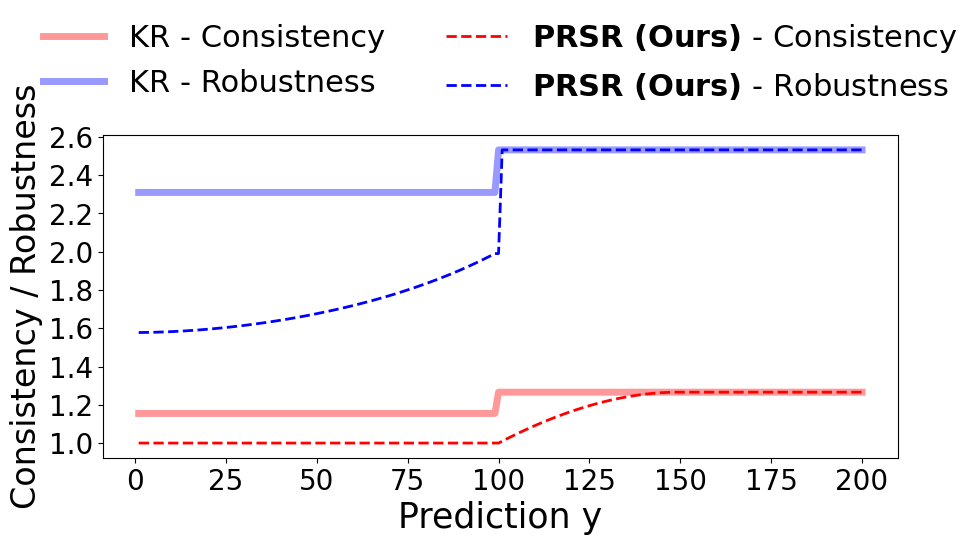

In [25]:
if __name__ == "__main__":
    plot_comparison(lambda_=0.5, b=100)

/var/folders/3v/p3bmjb3n73l95z9dcb8kb8880000gn/T/ipykernel_26454/145372099.py:84: RuntimeWarning: invalid value encountered in scalar divide
  return (part1 + part2) / denom


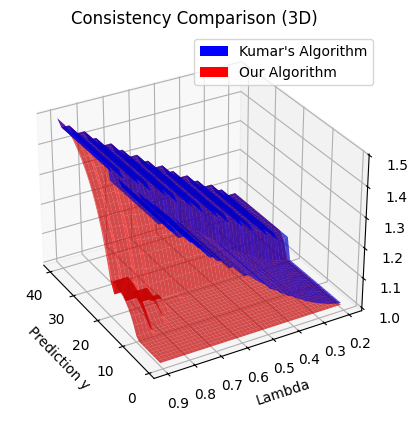

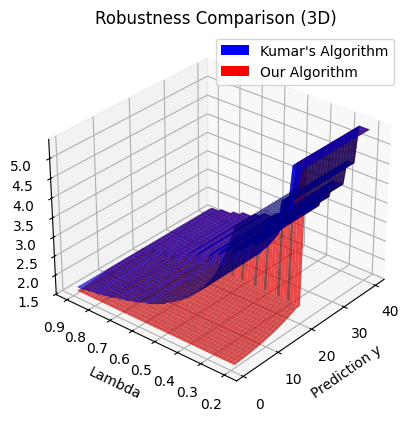

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Patch

def plot_comparison_3d_dual(b, elev1=30, azim1=45, elev2=30, azim2=45):
    ys = np.arange(1, 2 * b + 1)
    lambdas = np.linspace(0.2, 0.9, 50)
    Y, LAMBDA = np.meshgrid(ys, lambdas)

    kumar_cons = np.zeros_like(Y, dtype=float)
    kumar_rob = np.zeros_like(Y, dtype=float)
    our_cons = np.zeros_like(Y, dtype=float)
    our_rob = np.zeros_like(Y, dtype=float)

    for i in range(len(lambdas)):
        for j in range(len(ys)):
            kc, kr, oc, orob = Kumar_vs_Ours(lambdas[i], b, ys[j])
            kumar_cons[i, j] = kc
            kumar_rob[i, j] = kr
            our_cons[i, j] = oc
            our_rob[i, j] = orob

    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111, projection='3d')
    ax1.plot_surface(Y, LAMBDA, kumar_cons, color='blue', alpha=0.7)
    ax1.plot_surface(Y, LAMBDA, our_cons, color='red', alpha=0.7)

    ax1.set_xlabel('Prediction y')
    ax1.set_ylabel('Lambda')
    ax1.set_zlabel('Consistency')
    plt.title('Consistency Comparison (3D)')

    ax1.view_init(elev=elev1, azim=azim1)

    # Legend
    legend_elements = [Patch(facecolor='blue', label="Kumar's Algorithm"),
                       Patch(facecolor='red', label="Our Algorithm")]
    ax1.legend(handles=legend_elements, loc='upper right')

    plt.show()

    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111, projection='3d')
    ax2.plot_surface(Y, LAMBDA, kumar_rob, color='blue', alpha=0.7)
    ax2.plot_surface(Y, LAMBDA, our_rob, color='red', alpha=0.7)

    ax2.set_xlabel('Prediction y')
    ax2.set_ylabel('Lambda')
    ax2.set_zlabel('Robustness')
    plt.title('Robustness Comparison (3D)')

    ax2.view_init(elev=elev2, azim=azim2)

    ax2.legend(handles=legend_elements, loc='upper right')

    plt.show()

if __name__ == "__main__":
    plot_comparison_3d_dual(
        b=20, 
        elev1=30, azim1=150, 
        elev2=30, azim2=220   
    )